In [31]:
%load_ext autoreload
%autoreload 2
import os
if os.path.basename(os.path.abspath(os.curdir)) == 'notebook':
    os.chdir('../.')

import sys
import torch
import os 
import sys
import pickle
from sketch_gnn.utils import flat_array
from sketch_gnn.dataloader.generate_dataModule import SketchGraphDataModule, generate_dataset
from sketch_gnn.models.gat import GaT
from sketch_gnn.utils.to_dict import parse_config
from sketch_gnn.utils.logger import logger

SAVED_MODEL_PATH= '/home/f49681/data/sg/models/v001/gat-epoch=48-val_loss=0.28.ckpt'
# SAVED_MODEL_PATH= '/home/f49681/data/sg/models/v004/gat-epoch=102-val_loss=0.00.ckpt'
SEQUENCE_DATA= 'data/normalization_output_merged.npy'

# Load config
conf = parse_config('config/gat.yml')
d_train = conf.get('train')
d_val_data = conf.get('val_data')
d_train['batch_size'] = 1
d_val_data['prop_max_edges_given'] = 0
with open(conf.get('prep_parms_path'), 'rb') as f:
    d_prep = pickle.load(f)

# Load Model
d_model = conf.get('model')
device = 'cpu'
model = GaT(d_model, d_prep)
model.to(device)
state_dict = torch.load(SAVED_MODEL_PATH, map_location=torch.device('cpu'))['state_dict']
new_state_dict = {}
for k,v in state_dict.items():
    new_key = k[6:] # remove 'model.' from key names
    new_state_dict[new_key] = v

model.load_state_dict(new_state_dict)
model.train(False)

# Load dataloder 
graph_datamodule = SketchGraphDataModule(conf, d_prep)
dataloader = graph_datamodule.val_dataloader()
batch_iterator = iter(dataloader)

# Load sequence dataset for visualization
sequence_data = flat_array.load_flat_array(SEQUENCE_DATA)

EDGE_IDX_MAP = d_prep.get('edge_idx_map')
NODE_IDX_MAP = d_prep.get('node_idx_map')




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Evaluate output

In [2]:
from sketch_gnn.inference.eval import EvalPrediction

batch = next(batch_iterator)
output = model(batch)
pred = EvalPrediction(batch,output,EDGE_IDX_MAP,threshold=0.95)
pred.print_prediction()

----------INFERRED----------
Label: COINCIDENT                    inferred: COINCIDENT                                    score= 1.00      
Label: None                          inferred: COINCIDENT                                    score= 1.00      INCORRECT
Label: None                          inferred: HORIZONTAL                                    score= 0.99      INCORRECT
Label: None                          inferred: COINCIDENT                                    score= 0.99      INCORRECT
Label: None                          inferred: COINCIDENT                                    score= 0.99      INCORRECT
Label: COINCIDENT                    inferred: COINCIDENT                                    score= 0.99      
Label: None                          inferred: COINCIDENT                                    score= 0.96      INCORRECT
Label: None                          inferred: PARALLEL                                      score= 0.95      INCORRECT


----------MISSED----------


## Visualize sketches
requires Sam

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

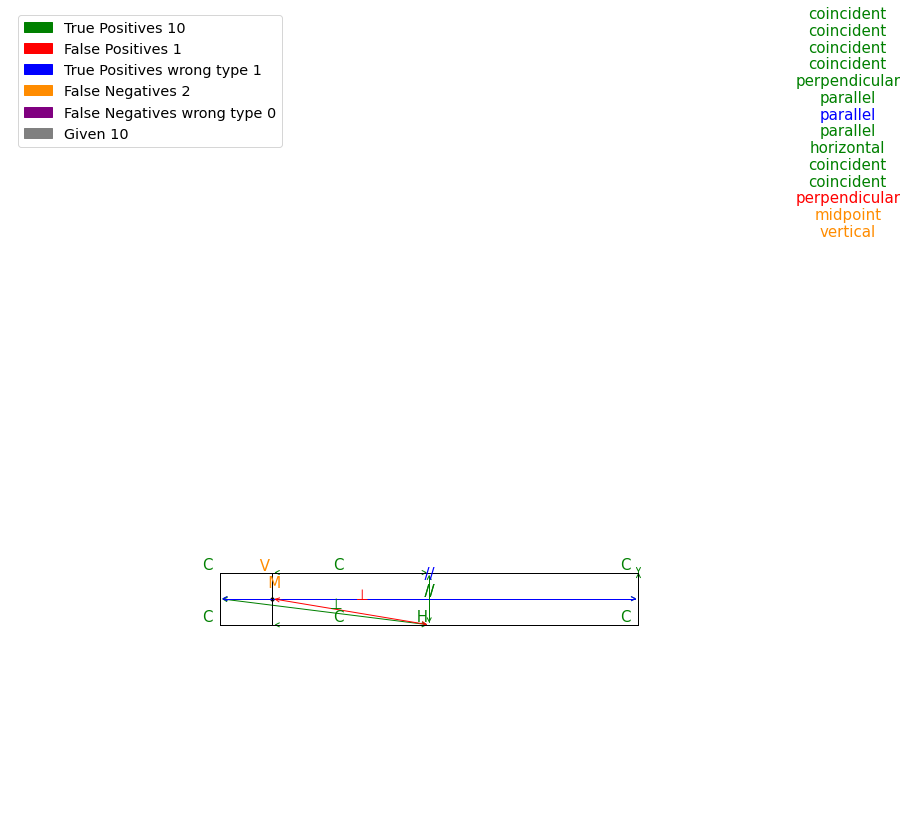

In [69]:
from sam.sketch import Sketch
from sketch_gnn.inference.visualization import display_constraint, display_inference, display_specific_constraint, filter_edges_for_visu

batch = next(batch_iterator)
output = model(batch)
pred = EvalPrediction(batch,output,EDGE_IDX_MAP,threshold=0.90)
seq_idx = batch['sequence_idx'][0]
sketch = Sketch()
sketch.sequence = sequence_data[seq_idx]
display_specific_constraint(sketch, pred, request=-1)

## Interactive plots

requires ipywidgets

In [28]:
from ipywidgets import interact, widgets
import warnings
from sam.constraint import Constraint

def interactive_sketch(sketch):
    def f(n):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            display_constraint(sketch,n)
    n_constraints = len([op for op in sketch.sequence if isinstance(op,Constraint)])-1
    interact(f,n=widgets.IntSlider(min=-1,max=n_constraints,step=1,value=-1))

def interactive_inference(sketch,pred,categories=None):
    def f(n):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            display_specific_constraint(sketch,pred,request=n,hide_tp=False,hide_given=False,categories=categories)
    # count elements to display
    n_constraints = len(filter_edges_for_visu(pred,hide_tp=False,hide_given=False,categories=categories))-1
    interact(f,n=widgets.IntSlider(min=-1,max=n_constraints,step=1,value=-1))

In [29]:
batch = next(batch_iterator)
output = model(batch)
pred = EvalPrediction(batch,output,EDGE_IDX_MAP,threshold=0.95)
seq_idx = batch['sequence_idx'][0]
sketch = Sketch()
sketch.sequence = sequence_data[seq_idx]
interactive_inference(sketch, pred)

interactive(children=(IntSlider(value=-1, description='n', max=22, min=-1), Output()), _dom_classes=('widget-i…

In [59]:
batch = next(batch_iterator)
output = model(batch)
pred = EvalPrediction(batch,output,EDGE_IDX_MAP,threshold=0.95)
seq_idx = batch['sequence_idx'][0]
sketch = Sketch()
sketch.sequence = sequence_data[seq_idx]
interactive_sketch(sketch)

interactive(children=(IntSlider(value=-1, description='n', max=23, min=-1), Output()), _dom_classes=('widget-i…